<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/main/lab01_speech_audio/HarmonicSignals.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a> 
# Pitch and Timbre of Periodic Signals (sine, square, sawtooth,  ...)
____   

## Do all the imports, define some synthesizer functions and UI
You need to run the first couple of cells first before starting the demos   
After that you can run the different demos in any order

In [5]:
# if needed, uncomment the pip install command to install pyspch -- it is required!
#
#!pip install git+https://github.com/compi1234/pyspch.git
#
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        %pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [6]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive, interactive_output
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
from IPython.display import display, clear_output, Audio, HTML
import time, copy, math
import librosa

import pyspch.sp as Sps
import pyspch.display as Spd
from pyspch.core import EPS_FLOAT

In [7]:
# The following code will increase the default width of your Jupyter notebook cells
# Supposed to work well 
display(HTML(data="""
<style>
    div#notebook-container    { width: 99%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# a default boxed layout
def box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

In [8]:
class Harmonic_Signals(widgets.HBox):
    def __init__(self,dur=1.,sample_rate=16000,freq_range=[100.,500.],figsize=(10,6),dpi=72):
        super().__init__()
        
        if sample_rate < 4000.:
            print("WARNING: sampling rate should not be lower than 4000.0 Hz and has been reset.")
            sample_rate = 4000.0
        self.sample_rate = sample_rate
        self.dur = dur/2.        
        display_types = ['spectrum','spectrogram']
        scale_types =['dB', 'Magnitude', 'Power']
        signal_types = [ 'sin', 'square', 'triangle', 'sawtooth', 'pulsetrain','chirp 1:20','chirp 20:1', 'gausspulse','modulated white noise','Dual Tone']
        
        self.disptype = 'spectrum'
        self.scaletype = 'dB'
        self.sigtype = 'sin'
        self.freq = 220.
        self.amp = 1.
        self.phi = 0.
        self.autoplay = False

        # create the widgets
        self.wg_disptype = widgets.Dropdown(options=display_types,value=self.disptype,description="Display")
        self.wg_scaletype = widgets.Dropdown(options=scale_types,value=self.scaletype,description="Scaling")
        self.wg_sigtype = widgets.Dropdown(options=signal_types,value=self.sigtype,description="Signal")
        self.wg_dur = widgets.FloatSlider(value=self.dur,step=0.1,min=.2,max=2.*self.dur,description='Duration',continous_update=False)
        self.wg_amp = widgets.FloatSlider(value=self.amp,step=0.05,min=0.05,max=1.0,description='Amplitude',continous_update=False)
        freq_step = 10. if (freq_range[1]-freq_range[0]) > 50 else 1.  
        self.wg_freq = widgets.FloatSlider(value=self.freq,step=freq_step,min=freq_range[0],max=freq_range[1],description='Frequency',continous_update=False)
        self.wg_phi = widgets.FloatSlider(value=self.phi,step=0.1,min=0.0,max=2.*np.pi,description='Phase',continous_update=False)
        self.wg_autoplay = widgets.Checkbox(value=self.autoplay,description='Autoplay Audio',indent=False,button_style='warning')
        self.wg_autoplay.layout.width='50%'
        self.wg_clear_log = widgets.Button(description='Clear the log')
        self.wg_clear_log.layout.width='50%'
        
        # link to the widget observers
        self.wg_disptype.observe(self.disptype_observe,'value')
        self.wg_scaletype.observe(self.scaletype_observe,'value')
        self.wg_sigtype.observe(self.sigtype_observe,'value')
        self.wg_dur.observe(self.dur_observe,'value')
        self.wg_amp.observe(self.amp_observe,'value')    
        self.wg_freq.observe(self.freq_observe,'value')
        self.wg_phi.observe(self.phi_observe,'value')
        self.wg_autoplay.observe(self.autoplay_clicked, 'value')
        self.wg_clear_log.on_click(self.clear_log_clicked)

        # setup the outputs 
        self.audio = widgets.Output()
        self.logscr = widgets.Output()
        self.out = widgets.Output(layout=box_layout())
        self.UI = widgets.VBox( [self.wg_disptype, self.wg_scaletype, self.wg_sigtype, self.wg_dur, self.wg_amp, self.wg_freq, self.wg_phi,self.wg_autoplay],
                                 layout=box_layout())
        
        self.right_screen = widgets.VBox([self.UI, self.audio, self.wg_clear_log,  self.logscr],layout=box_layout())
                                          
        # initialize the plots
        #self.fig,self.ax = plt.subplots(2,1,constrained_layout=True, figsize=(9, 4))
        self.fig = Spd.SpchFig(row_heights=[1.,1.], figsize=figsize,dpi=dpi)        
        self.update()
        plt.close()          # avoids output of dummy figure on startup
        # initialize the displayed function

        # attach children to the VBox class
        self.children = [ self.out, self.right_screen ] 

    def update(self):
        y,t = Sps.synth_signal(sigtype=self.sigtype,freq=self.freq,phi=self.phi,amp=self.amp,sample_rate=self.sample_rate,dur=self.dur)

        ax = self.fig.axes
        ax[0].cla()
        ax[1].cla()
         
        if self.disptype == 'spectrum':
            freq_ax,spec_pow = signal.periodogram(y,fs=self.sample_rate,scaling='spectrum')
            # note: the 2.*spec is necessary to incorporate the duplicate information in negative frequencies 
            spec = 2.*spec_pow
            if self.scaletype == 'Power':
                ylabel = 'Power Spectrum'
                yrange = None
            elif self.scaletype == 'dB':
                spec = 10.0*np.log10(spec+EPS_FLOAT)
                ylabel = 'Log Spectrum (dB)'
                yrange = [-60, 2]
            elif self.scaletype == 'Magnitude':
                spec = np.sqrt(spec)
                ylabel = 'Magnitude Spectrum'
                yrange = None
            else:
                with self.logscr:
                    print("scaletype not known:",self.scaletype)

            self.fig.add_line_plot(y,iax=0,x=t,yrange=[-1,1.],xlabel='Time(sec)',title='Waveform')
            self.fig.add_line_plot(spec,iax=1,x=freq_ax,yrange=yrange,xlabel='Frequency (Hz)',ylabel=ylabel,title='Spectrum',grid=True)
            
        elif self.disptype == 'spectrogram':
            spg_pow = Sps.spectrogram(y,sample_rate=self.sample_rate,preemp=0.)
            if self.scaletype == 'Power':
                spg = spg_pow
            elif self.scaletype == 'dB':
                spg = 10.0*np.log10(spg_pow + EPS_FLOAT)
            elif self.scaletype == 'Magnitude':
                spg = np.sqrt(spg_pow)
                
            self.fig = Spd.PlotSpg(spgdata=spg,wavdata=y,sample_rate=self.sample_rate,
                            dy=None,ylabel="Frequency(Hz)",title="Waveform and Spectrogram")
            
        # here come the things that go to dedicated output widgets
        with self.out:
            clear_output(wait=True)
            display(self.fig)
        with self.audio:
            clear_output(wait=True)
            try:
                display(Audio(data=y,rate=self.sample_rate,normalize=False, autoplay=self.autoplay))
            except: 
                try:
                    with self.logscr:
                        #clear_output(wait=True)
                        print("Warning: playing normalized sound")
                    display(Audio(data=y,rate=self.sample_rate, autoplay=self.autoplay))
                except: pass
     
    def disptype_observe(self,change):
        self.disptype = change.new
        self.update()
        
    def scaletype_observe(self,change):
        self.scaletype = change.new
        self.update()
        
    def sigtype_observe(self,change):
        self.sigtype = change.new
        self.update()
    
    def dur_observe(self,change):
        self.dur = change.new
        self.update()
        
    def amp_observe(self,change):
        self.amp = change.new
        self.update()
        
    def freq_observe(self,change):
        self.freq = change.new
        self.update()
        
    def phi_observe(self,change):
        self.phi = change.new
        self.update()
        
    def autoplay_clicked(self,obj):
        self.autoplay = not self.autoplay
        with self.logscr: print('Toggling autoplay',self.autoplay) 

    def clear_log_clicked(self,b):
        with self.logscr: clear_output()                   



## Fourier Synthesis of a Square Wave



#### Background
From Fourier theory we know that any periodic signal can be generated by adding up sine waves of harmonics of the fundamental frequency with
appropriate amplitude and phase:

$y(t) = \sum_k A_k  sin(2  \pi k f_0 t+\Phi_k)$

For a square wave the amplitudes are 1/k for the odd harmonics and 0 for the even harmonics; all phase terms are zero, thus:

$y(t) = \sum_{k=1,3,5..} \frac{1}{k} sin(2  \pi k f_0 t)$


#### GUI control
The parameters that you have under control are:
- The fundamental frequency $f_0$  
- The number (N) of harmonics that are added to the harmonic complex
- The duration (dur) of the signal that is generated

You can play the synthesized sound at the bottom of the interface

#### Things to investigate
- What does the approximation look like when using 2 harmonics ?
- What does the approximation look like when using 100 harmonics ?
- When putting N=7, I see 4 harmonics displayed in the spectrum. Explain.
- Set your parameters such that you can observe individual periods well; Describe what you see.

interactive(children=(IntSlider(value=1, description='N', min=1), FloatSlider(value=220.0, description='f0', m…

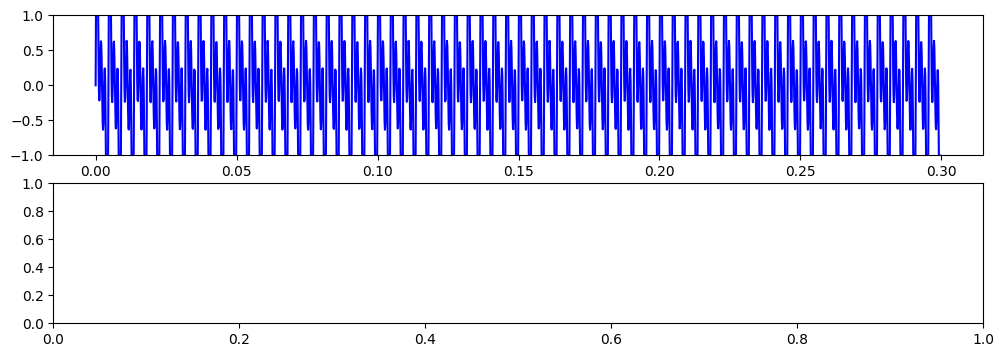

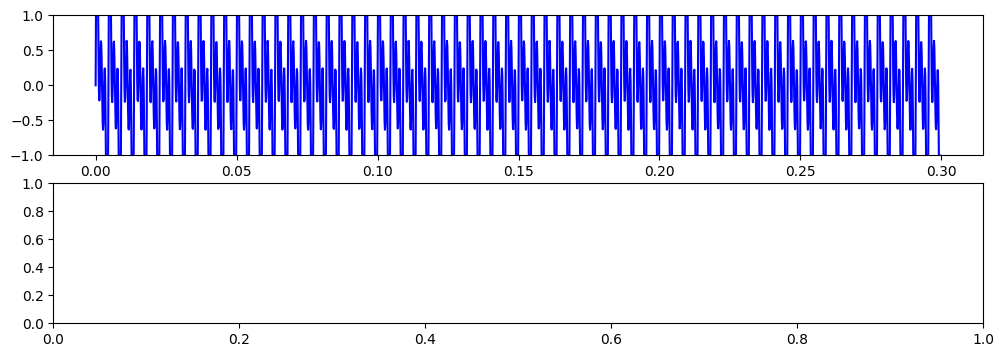

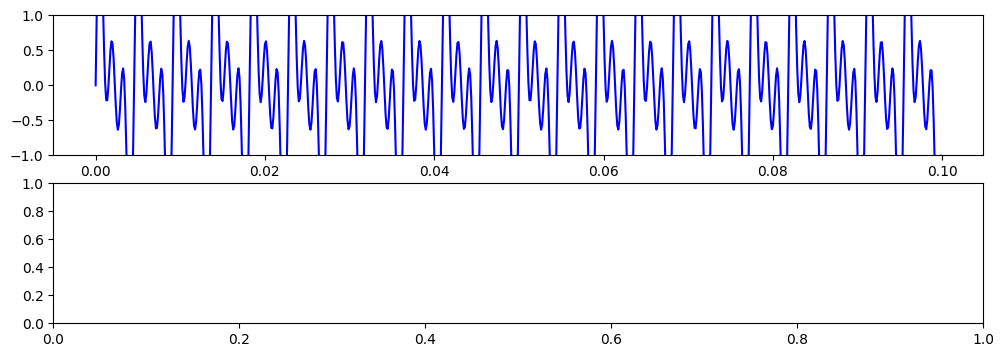

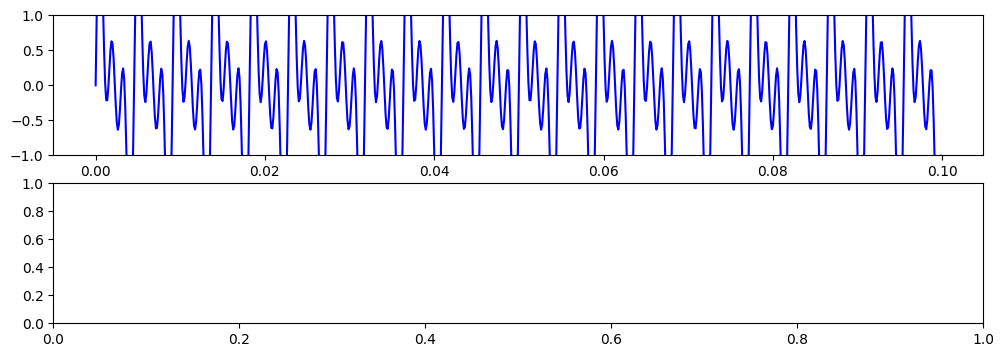

In [9]:
def synt_square_wave(N,f0,dur=0.25):
    # generate a harmonic complex with the appropriate amplitudes
    sample_rate = 8000
    freqs = np.arange(f0,(N+1)*f0,f0)
    amps = np.zeros((N,))
    for k in range(N):
        if (k+1)%2 == 1: amps[k] = 1./(k+1)
    # Fourier Synthesis
    y,t = Sps.synth_fourier(freqs=freqs,amps=amps,dur=dur,sample_rate=sample_rate)
    fig, ax = plt.subplots(2,figsize=(12, 4),dpi=100)
    ax[0].plot(t,y)
    ax[0].set_xlabel('Time(sec)')
    ax[0].set_ylim([-1,1])
    ax[1].vlines(freqs,0,amps,'r')
    ax[1].set_xlim([0.,sample_rate/2])
    ax[1].set_ylim([0.,1.])
    ax[1].set_xlabel('Frequency(Hz)')
    ax[1].set_ylabel('Amplitude')
    fig.subplots_adjust(hspace=0.4)
    plt.close()

    clear_output(wait=True)
    display(fig)
    display(Audio(y,rate=sample_rate))

interact(synt_square_wave,N=widgets.IntSlider(min=1,max=100),
         f0=widgets.FloatSlider(value=220.,min=10.,max=1000.,step=10.),
         dur=widgets.FloatSlider(value=0.3,min=.1,max=1.));

# Pitch and Timbre of harmonic (and pseudo-harmonic) signals

#### Pitch of Pure Tones

Pitch is often defined as the characteristic of a sound that makes it sound high or
low, or that determines its position on a musical scale. Pitch is related to the repetition
rate of the waveform of a sound. For a pure tone, this corresponds to the frequency; for
a 'complex tone it usually (but not always) corresponds to the fundamental frequency.
Frequency is the most important contributor to the sensation of pitch, but not the only
one by any means. Other contributors to pitch include intensity, spectrum, duration,
amplitude envelope, and the presence of other sounds.
Various attempts have been made to establish a psychophysical pitch scale. If, after
listening to a 4000-Hz tone followed by a tone of very low frequency, one is asked to
tune an oscillator to a pitch halfway between, a likely choice would be around 1000 Hz.
On a scale of pitch, then, 1000 Hz is judged halfway between 0 and 4000 Hz. The unit
for subjective pitch is the mel the scale which is arranged so that doubling the number of mels
doubles the subjective pitch. A scale from 0 to 2400 mels covers the audible range of
20 to 16,000 Hz.   

A numerical scale of pitch (in mels) is not nearly so useful as a numerical scale
of loudness (in sones), however. Pitch is more often related to a musical scale, where
the octave is the "natural" pitch interval that is subdivided into the desired number of
steps.
Two major theories of pitch perception have been developed; they are usually referred to as the place (or frequency) theory and the periodicity (or time) theory. According to the place theory, the cochlea converts a vibration in time to a vibration pattern
in space (along the basilar membrane), and this in turn excites a spatial pattern of
neural activity. The place theory explains some aspects of auditory perception but fails
to explain others.
According to the periodicity theory of pitch, the ear performs a temporal analysis
of the sound wave. Presumably, the time distribution of impulses carried along the
35 
auditory nerve has encoded into it the temporal structure of the sound wave.

##### Note on mel scale(s)
There is not really a universally accepted mel scale.  Different variants 
are in use, both with respect to scaling with respect  to absolute values:
- when you see values 0-2400 mel: it will imply that 'mel' and 'Hz' will be very similar up to 1000Hz
- when you see values 0-24: it relates to critically spaced mel channels and 1 mel corresponds to about 100Hz below 1kHz

  

#### Pitch of Complex Tones

One of the most remarkable properties of the auditory system is its ability to extract
pitch from complex tones. When the complex tone consists of a number of harmonically
related partials, the pitch corresponds to the "missing fundamental." This pitch is often
referred to as pitch of the missing fundamental, virtual pitch, or musical pitch.
When the partials are not exactly harmonics of a missing fundamental, we arrive at
a "virtual pitch" by some strategy that may weigh several possibilities, and when the
choice is difficult the pitch may be ambiguous.
Familiar examples of such virtual pitch are the bass notes we hear from loudspeakers
of very small size that radiate negligible power at low frequencies, and the subjective
strike note of carillon bells, tuned church bells and orchestral chimes.

#### Timbre

The American National Standards Institute defines timbre as " ... that attribute of
auditory sensation in terms of which a listener can judge that two sounds similarly
presented and having the same loudness and pitch are dissimilar". According to this
definition, timbre is the subjective correlate of all those sound properties that do not
directly influence pitch or loudness. These properties include the sound's spectral power
distribution, its temporal envelope (as would be shown on an oscilloscope display), rate
and depth of amplitude or frequency modulation, and the degree of inharmonicity of
its partials. The timbre of a sound therefore depends on many physical variables. It
has been shown that from a subjective point of view the sensation of timbre has about
three rather orthogonal dimensions. These can be represented by the verbal ranges dullsharp, compact-scattered and colorful-colorless. These subjective dimensions are loosely
related to the physical quantities of high-frequency energy in the attack, synchronicity
in high-harmonic transients, and spectral power distribution.
The concept of timbre plays a very important role in the orchestration of traditional
music and in the composition of computer music. There is, however, no satisfying
comprehensive theory of timbre perception. Neither is there a uniform nomenclature
to designate or classify timbres. This poses considerable problems in communicating or
teaching the skills of orchestration and computer score writing to student-composers.
In the following demonstrations one can hear how spectral make-up, temporal envelope and degree of spectral inharmonicity all have a very specific influence on the
perceived timbre of sounds from musical instruments. 

(For a demo with musical instruments, see **Demo 28 in AuditoryDemonstrations**)

#### The Analytical Perspective

Periodic signals can be expressed as a harmonic complex of sine waves.

$y= A \sum_k \alpha_k  sin(2  \pi k f_0 t+\Phi)$

The same formula can be applied to pseudo harmonic signals, that have either time-varying amplitude (e.g. Gaussian pulse) or time-varying frequency (e.g. chirps). 



## The Harmonic_Signals GUI

#### Control Parameters
- The fundamental frequency $f_0$  (named "frequency" in the control panel)  
- The overall amplitude $A$
- The relative amplitude of the harmonics $\alpha_k$ by choosing from a set of predefined harmonic functions
- The global phase $\Phi$  (you cannot control relative phase differences per harmonic component in this GUI)

#### Signal Types to choose from:
- stationary and periodic
    + sine wave
    + square 
    + sawtooth
- non stationary signals:
    + chirp 1:20 : ramping up the frequency by a factor of 20
    + chirp 20:1 : ramping down the frequency by a factor of 20
    + gausspulse
    + modulated white noise
    + Dual Tone : this generates a non-harmonic two tone compound, quite similar to the familiar DTMF tones (f2=1.735\*f1) 

#### Displays to choose from:
- spectrum: 
    + The 'spectrum' display shows the Fourier spectrum computed over the whole signal
    + This is a simple representation and appropiate for stationary signals (what most of the signals here are)
- spectrogram: 
    + The 'spectrogram' display shows the evolution of the spectrum over time in a heatmap representation
    + This is achieved by computing Fourier spectra over short time windows (30msec only!)
    + This is best used for time varying signals such as the chirps in this demo, and is our preferred representation for most acoustical signals including audio

## Things to investigate:
- Start of with a sin wave as signal and the standard spectrum display
    - play different tones at different frequencies in the 50Hz - 1000Hz range; what differences do you hear
    - choose a rather low frequency and play with the phase; what differences do you see in the signal, wat differences do you hear ?
- Now, adjust the 'signal' type, i.e. choose between sin, triangle, square wave and sawtooth.
    + keep frequency, amplitude, duration and phase fixed (e.g. f=250Hz, T=0.2sec)
    + what is same and what is different in the perception when changing the signal type
- Chirp signal
    + set the frequency to 250Hz, and choose a 'chirp 1:20' signal; this will generate a tone with frequency starting at 250Hz  and ending at 20\*250 = 5000 Hz
    + what does the spectrum look like and how do you perceive this chirp signal
    + now, in contrast play the chirp 20:1; what is the difference in perception and what is the difference in the spectrum
    + play with the 'duration' parameter, what are the changes in the spectrum
    + now change the view to spectrogram; and do the same analysis.  What spectral representation is more informative 'spectrum' or 'spectrogram' ?
    + finally ramp up the frequency to 500Hz and 1000Hz.
        - there are some dramatic changes: describe them perceptually and visually (spectrogram)
        - can you explain this ?
    + you can redo the final experiment at different sampling frequencies (8000, 16000, 48000). What is the most striking phenomenon and do you know it's cause?
- Listen to Gaussian pulses at varies frequencies. 
    + Just observe how these signals combine tonal and pulsatile perceptions in a short sound

    


In [10]:
Harmonic_Signals(sample_rate=16000,freq_range=[20.,2000.],figsize=(10,5)) 

Harmonic_Signals(children=(Output(layout=Layout(border_bottom='solid 1px black', border_left='solid 1px black'…

# Periodicity and Rhythm

#### Background
For a large group of sounds and speech in particular periodicity induces a *tonal* percept, ralso called *pitch*.
The pitch percept, however, fades away at the lower end of our hearing spectrum, i.e. around 20Hz.   
So we may wonder how do we percieved a periodicity of 10Hz or even 1Hz  ?   
We definitely do not perceive these slow repititions as a low frequency pitch.  
But on the other hand the regular recurrences of patterns in time at such low frequencies give us a sensation of rhythm, like the clapping of hands, the playing of musical notes on an instrument, etc.

With the same demo as before, we now focus on the very low (fundamental) frequency range.  
Focus on the 1Hz - 10Hz range, but you may play the same demo with a base frequency above 25Hz as well to hear the contrast.   

#### Things to investigate:
- sines from 1Hz to 50Hz
    + choose the "sin" (single tone) signal
    + set duration of the sound to 2 seconds and play a comfortably loud tone at 50Hz (to make sure that you are audio is working correctly)
    + gradually decrease the frequency of the tone in steps of 10Hz, describe what you hear 
- "modulated white noise" with (modulation) frequency from 1Hz to 50Hz
    + Set the frequency at 5Hz signal and 50Hz respectively.  Describe in your own words the difference in perception.
    + While the boundary is not clean, give a best estimate of the frequency boundary between the two types of signals
    + What does the spectrogram look like
- compare the auditive impression of a sine wave, a square wave and modulated white noise modulated with frequencies 5, 10 an 50 Hz
    + did you hear all sounds ? 
    + how do you explain that you did not hear one of them ?
- now, focus on a pulse train
    + generate a pulse train with frequency 10Hz and look at the spectrogram
    + now go back to the previous demo where you can generate a pulse train with a frequency of 500Hz
    + compare the perception of both and how this is reflected (or not) in long term spectrum and/or spectrogram

In [11]:
Harmonic_Signals(sample_rate=8000,freq_range=[1,50.],dur=10.,figsize=(8,5),dpi=72) 

Harmonic_Signals(children=(Output(layout=Layout(border_bottom='solid 1px black', border_left='solid 1px black'…

In [12]:
#! jupyter nbconvert HarmonicSignals.ipynb --to html